## Deep Research

One of the classic cross-business Agentic use cases! This is huge.

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/business.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00bfff;">Commercial implications</h2>
            <span style="color:#00bfff;">A Deep Research agent is broadly applicable to any business area, and to your own day-to-day activities. You can make use of this yourself!
            </span>
        </td>
    </tr>
</table>

### Upgrades to Original System

- When given a query, come up with 3 questions that will help answer the query
    - Then come up with a search query to answer each question
- Incorporate handoffs and using agents as tools
    - Agents as Tools: 1 Google Search agent and 1 OpenAI Web Search agent. The research manager will decide if more queries are needed (and can call planner_agent again), or if need to run again.
    - Agents as Tools: 1 question formulator agent and 1 search planner agent which get used by the research manager in sequence.
    - Handoff the research to the writer agent
    - Handoff the report to the editor agent

PLAN
- Create & test question_formulator_agent
    - Given a query, formulate X research questions to help answer the query
    - Test with a query
    - Convert to .as_tool()
- Adjust previous planner_agent & test
    - Use the question_formulator_agent as a tool to generate questions
    - Create 1 search query to answer each 1 of the questions
    - Test with simulated questions
    - Convert to .as_tool()
- Create & test gemini_search_agent
    - Someone has a version in the community contributions folder
    - Take the list of queries and perform a search for each one
    - Test with simulated query list
    - Convert to .as_tool()
- Adjust previous openai_search_agent & test
    - Take the list of queries and perform a search for each one
    - Test with simulated query list
    - Convert to .as_tool()
- Create an editor_agent
    - Receives the report and edits it to a professional level
    - Returns the same as writer_agent
- Adjust the writer_agent
    - Receives the research, writes a report, also returns a markdown report
    - Handsoff to editor_agent
- Create a research_manager_agent
    - Given a query use the planner_agent to generate search queries to research the query
    - Next use the gemini_search_agent and openai_search_agents to conduct the search queries. They should each be used once for every search query. That way you receive two different results to consider for each query for the final research report. If you believe more information is needed to address the query, you can use the planner_agent only one additional time followed by the gemini_search_agent and the gemini_search_agent to gather additional research. You will then handoff this research to the writer_agent to write a report.

In [222]:
from agents import Agent, WebSearchTool, trace, Runner, function_tool, handoff
from agents.model_settings import ModelSettings
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import asyncio
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
from typing import Dict
from IPython.display import display, Markdown
from agents import OpenAIChatCompletionsModel
from openai import AsyncOpenAI
import requests
from bs4 import BeautifulSoup

In [223]:
load_dotenv(override=True)

True

### Question Formulator Agent
- Create & test question_formulator_agent
    - Given a query, formulate X research questions to help answer the query
    - Test with a query
    - Convert to .as_tool()

In [224]:
INSTRUCTIONS = "You are a helpful research assistant. Given a query, formulate a set of research questions \
that when answered will help answer or address the query. Output 3 questions to research."

class ResearchQuestionItem(BaseModel):
    reason: str = Field(description="Your reasoning for why this question is important to address the query.")
    question: str = Field(description="The research question to use to conduct further research regarding the query.")

class ResearchQuestionPlan(BaseModel):
    questions: list[ResearchQuestionItem] = Field(description="A list of research questions to research to best answer the query.")

question_formulator_agent = Agent(
    name="Question Formulator Agent",
    instructions=INSTRUCTIONS,
    model="gpt-4o-mini",
    output_type=ResearchQuestionPlan,
)

In [201]:
message = "Latest AI Agent frameworks in 2025"

with trace("Test - Question Formulator Agent"):
    result = await Runner.run(question_formulator_agent, message)

print(result.final_output)

questions=[ResearchQuestionItem(reason='Understanding the foundational elements of AI agent frameworks will provide insight into their development and capabilities.', question='What are the key features and technologies that define the leading AI agent frameworks introduced in 2025?'), ResearchQuestionItem(reason='Evaluating the real-world applications of these frameworks will highlight their impact and effectiveness in various industries.', question='What industries are adopting AI agent frameworks in 2025, and what are the specific use cases driving their implementation?'), ResearchQuestionItem(reason='Keeping up with the latest advancements in AI frameworks is crucial for identifying trends and potential future developments.', question='What are the emerging trends and innovations in AI agent frameworks as observed in 2025?')]


In [225]:
description = "Generate research questions"

tool_question_formulator = question_formulator_agent.as_tool(tool_name="question_formulator_agent", tool_description=description)

tools_for_planner_agent = [tool_question_formulator]

tools_for_planner_agent

[FunctionTool(name='question_formulator_agent', description='Generate research questions', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'question_formulator_agent_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x1196596c0>, strict_json_schema=True, is_enabled=True)]

### Planner Agent
- Adjust previous planner_agent & test
    - Use the question_formulator_agent as a tool to generate questions
    - Create 1 search query to answer each 1 of the questions
    - Test with simulated questions
    - Convert to .as_tool()

In [226]:
INSTRUCTIONS = "You are a helpful research assistant. Given a query you will use the question_formulator_agent as a tool to \
come up with a set of questions. Your role is to create 1 web search for each question to perform to best answer the query. \
Output the web search terms to query for, there should be exactly as many web search queries as questions you received."

class WebSearchItem(BaseModel):
    reason: str = Field(description="Your reasoning for why this search is important to the query and will answer the question.")
    query: str = Field(description="The search term to use for the web search.")

class WebSearchPlan(BaseModel):
    searches: list[WebSearchItem] = Field(description="A list of web searches to perform to best answer the query.")

planner_agent = Agent(
    name="Planner Agent",
    instructions=INSTRUCTIONS,
    model="gpt-4o-mini",
    output_type=WebSearchPlan,
    tools=tools_for_planner_agent
)

In [204]:
message = "Latest AI Agent frameworks in 2025"

with trace("Test - Planner Agent"):
    result = await Runner.run(planner_agent, message)
    print(result.final_output)

searches=[WebSearchItem(reason='Understanding the leading frameworks will provide insight into current technological advancements and trends in AI agents.', query='most popular AI agent frameworks 2025 features'), WebSearchItem(reason='Identifying the challenges faced by developers will highlight areas needing improvements and innovation in the field.', query='challenges developers AI agent frameworks 2025'), WebSearchItem(reason='Assessing the impact of integration can reveal how AI agents are transforming industries and workflows.', query='AI agent frameworks integration into industries 2025')]


In [227]:
description = "Generate web search terms"

tool_planner_agent = planner_agent.as_tool(tool_name="planner_agent", tool_description=description)
tools_for_research_manager_agent = [tool_planner_agent]
tools_for_research_manager_agent

[FunctionTool(name='planner_agent', description='Generate web search terms', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'planner_agent_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x119658400>, strict_json_schema=True, is_enabled=True)]

### Gemini Search Agent
- Create & test gemini_search_agent
    - Someone has a version in the community contributions folder
    - Take the list of queries and perform a search for each one
    - Test with simulated query list
    - Convert to .as_tool()

In [229]:
GEMINI_BASE_URL = "https://generativelanguage.googleapis.com/v1beta/openai"
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GOOGLE_CUSTOM_SEARCH_API_KEY = os.getenv("GOOGLE_CUSTOM_SEARCH_API_KEY")
GOOGLE_CSE_ID = os.getenv("GOOGLE_CSE_ID")

gemini_client = AsyncOpenAI(base_url=GEMINI_BASE_URL, api_key=os.getenv('GOOGLE_API_KEY'))
gemini_model = OpenAIChatCompletionsModel(model="gemini-2.0-flash",openai_client=gemini_client)

In [230]:
# Tool for Web Search - Google doesn't offer a remote WebSearchTool like OpenAI

@function_tool
async def google_web_search(query: str) -> str:
    """
    Performs a Google Search and returns a string of concatenated result snippets.
    """
    endpoint = "https://www.googleapis.com/customsearch/v1"
    params = {
        "key": GOOGLE_CUSTOM_SEARCH_API_KEY,
        "cx": GOOGLE_CSE_ID,
        "q": query,
        "num": 5,  # Number of results to fetch
    }

    response = requests.get(endpoint, params=params)
    if response.status_code != 200:
        raise RuntimeError(f"Google Search API error {response.status_code}: {response.text}")

    data = response.json()
    items = data.get("items", [])

    if not items:
        return "No results found."

    # Combine title and snippet for each result
    result_texts = []
    for item in items:
        title = item.get("title", "").strip()
        snippet = item.get("snippet", "").strip()
        link = item.get("link", "").strip()
        result_texts.append(f"{title}\n{snippet}\n{link}")

    summary = "\n\n".join(result_texts)
    return summary

In [231]:
INSTRUCTIONS = "You are a research assistant. Given a web search term, you search the web using the google_web_search tool \
for that term and produce a concise summary of the results. The summary must 5-8 paragraphs and between 500-1000 words \
words. Capture the main points. Write succintly, add evidence/facts, no need to have complete sentences or good \
grammar. This will be consumed by someone synthesizing a report, so it's vital you capture the \
essence and ignore any fluff. Do not include any additional commentary other than the summary itself."

gemini_search_agent = Agent(
    name="Gemini Search Agent",
    instructions=INSTRUCTIONS,
    tools=[google_web_search],
    model=gemini_model,
    model_settings=ModelSettings(tool_choice="required"),
)

In [211]:
message = "notable AI agent frameworks introduced or updated in 2025"

with trace("Test - Gemini Search Agent"):
    result = await Runner.run(gemini_search_agent, message)

display(Markdown(result.final_output))

Based on the search results, here's a summary of notable AI agent frameworks introduced or updated in 2025:

**General Landscape**

*   The field of AI agent frameworks is rapidly expanding and evolving in 2025.
*   New tools, connectors, and community contributions are continuously emerging.
*   Microsoft and Google are key players, introducing new models and tools.

**Specific Frameworks and Updates**

*   **Hugging Face Transformers Agents:** Leverages the power of transformer models.
*   **LangChain:** The ecosystem is continuously growing.
*   **Microsoft Azure AI:** Enhanced with enterprise-grade agents.
*   **Google Agent Development Kit (ADK):** Facilitates building multi-agent applications, compatible with models like Gemini and those in Vertex AI Model Garden.

**Key Announcements and Events**

*   **Microsoft Build 2025:** Focused on AI agents and building an open agentic web, putting new models and coding agents in developers' hands.

In short, 2025 sees considerable advancement in AI agent frameworks, with key players like Microsoft, Google, and Hugging Face introducing new tools and updates. The focus is on expanding capabilities, accessibility, and enterprise-grade solutions for AI agents.


In [232]:
description = "Search the web using Google Search"

tool_google_search = gemini_search_agent.as_tool(tool_name="gemini_search_agent", tool_description=description)

In [233]:
tools_for_research_manager_agent.append(tool_google_search)
tools_for_research_manager_agent

[FunctionTool(name='planner_agent', description='Generate web search terms', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'planner_agent_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x119658400>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='gemini_search_agent', description='Search the web using Google Search', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'gemini_search_agent_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x11961bce0>, strict_json_schema=True, is_enabled=True)]

### OpenAI Search Agent
- Adjust previous openai_search_agent & test
    - Take the list of queries and perform a search for each one
    - Test with simulated query list
    - Convert to .as_tool()
    

In [234]:
INSTRUCTIONS = "You are a research assistant. Given a web search term, you search the web \
for that term and produce a concise summary of the results. The summary must 5-8 paragraphs and between 500-1000 words \
words. Capture the main points. Write succintly, add evidence/facts, no need to have complete sentences or good \
grammar. This will be consumed by someone synthesizing a report, so it's vital you capture the \
essence and ignore any fluff. Do not include any additional commentary other than the summary itself."

openai_search_agent = Agent(
    name="Search Agent",
    instructions=INSTRUCTIONS,
    tools=[WebSearchTool(search_context_size="low")],
    model="gpt-4o-mini",
    model_settings=ModelSettings(tool_choice="required"),
)

In [170]:
message = "notable AI agent frameworks introduced or updated in 2025"

with trace("Search"):
    result = await Runner.run(openai_search_agent, message)

display(Markdown(result.final_output))

In 2025, several notable AI agent frameworks have been introduced or updated, reflecting significant advancements in the field.

**OpenAI's Operator**: Launched on January 23, 2025, Operator is an AI agent developed by OpenAI capable of autonomously performing tasks through web browser interactions, including filling forms, placing online orders, and scheduling appointments. It utilizes OpenAI's advanced models to expand practical automation capabilities for users in daily activities. Initially available to Pro-tier subscribers in the United States as a research preview, OpenAI plans to broaden its availability in the future. ([en.wikipedia.org](https://en.wikipedia.org/wiki/OpenAI_Operator?utm_source=openai))

**AutoAgent**: Introduced in February 2025, AutoAgent is a fully-automated, zero-code framework designed for Large Language Model (LLM) agents. It enables users to create and deploy LLM agents through natural language alone, without the need for programming skills. Operating as an autonomous Agent Operating System, AutoAgent comprises key components such as Agentic System Utilities, an LLM-powered Actionable Engine, a Self-Managing File System, and a Self-Play Agent Customization module. This lightweight yet powerful system facilitates efficient and dynamic creation and modification of tools, agents, and workflows without coding requirements or manual intervention. ([arxiv.org](https://arxiv.org/abs/2502.05957?utm_source=openai))

**Eliza**: In January 2025, Eliza was introduced as the first open-source, web3-friendly AI agent operating system. It seamlessly integrates web3 applications into AI agent functionalities, allowing for the reading and writing of blockchain data and interaction with smart contracts. Eliza emphasizes that every aspect of its runtime is a regular TypeScript program under the full control of its user, providing stability and performance. ([arxiv.org](https://arxiv.org/abs/2501.06781?utm_source=openai))

**Manus**: Launched on March 6, 2025, Manus is an AI agent capable of operating independently based on large language models. It can autonomously handle complex tasks, including writing and deploying code, marking a significant advancement in AI agent capabilities. However, in July 2025, Manus faced regional restrictions in China, with its official website displaying messages indicating that the service was unavailable in the region. ([en.wikipedia.org](https://en.wikipedia.org/wiki/Manus_%28AI_agent%29?utm_source=openai))

**Model Context Protocol (MCP)**: Introduced by Anthropic in November 2024, MCP is an open-source framework designed to standardize the way AI systems, like large language models, integrate and share data with external tools, systems, and data sources. It provides a universal interface for reading files, executing functions, and handling contextual prompts. In March 2025, OpenAI adopted MCP, integrating it across its products, including the ChatGPT desktop app and the OpenAI Agents SDK, to standardize AI tool connectivity. ([en.wikipedia.org](https://en.wikipedia.org/wiki/Model_Context_Protocol?utm_source=openai))

**NLWeb**: Introduced by Microsoft in 2025, NLWeb is an open Python project designed to simplify the creation of natural language interfaces for websites. It enables users to query website contents using natural language, similar to interacting with an AI assistant. Each instance functions as an MCP server, allowing websites to make their content discoverable and accessible to AI agents and other participants. ([en.wikipedia.org](https://en.wikipedia.org/wiki/NLWeb?utm_source=openai))

**Kruti**: Launched in June 2025 by Krutrim, Kruti is an agentic AI assistant designed to eliminate app-switch fatigue. It can accept documents, images, and text as input and uses an agentic framework where individual agents work together to efficiently complete a user's request. Kruti can function both as a platform and an AI agent, allowing for modification into domain-specific agents for diverse industries such as healthcare, education, and finance. ([en.wikipedia.org](https://en.wikipedia.org/wiki/Kruti?utm_source=openai))

These developments highlight the rapid evolution of AI agent frameworks in 2025, emphasizing increased autonomy, integration with web3 technologies, and enhanced user accessibility. 

In [235]:
description = "Search the web using OpenAI's WebSearchTool"

tool_openai_search = openai_search_agent.as_tool(tool_name="openai_search_agent", tool_description=description)

In [236]:
tools_for_research_manager_agent.append(tool_openai_search)
tools_for_research_manager_agent

[FunctionTool(name='planner_agent', description='Generate web search terms', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'planner_agent_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x119658400>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='gemini_search_agent', description='Search the web using Google Search', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'gemini_search_agent_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x11961bce0>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='openai_search_agent', description="Search the web using OpenAI's WebSearchTool", params_json_schema={'properties': {'inpu

### Editor Agent
- Create an editor_agent
    - Receives the report and edits it to a professional level
    - Returns the same as writer_agent

In [237]:
class ReportData(BaseModel):
    short_summary: str = Field(description="A short 2-3 sentence summary of the findings.")
    markdown_report: str = Field(description="The final report")
    follow_up_questions: list[str] = Field(description="Suggested topics to research further")

In [238]:
INSTRUCTIONS = (
    "You are a senior editor tasked with editing and revising a cohesive report for a research query. "
    "You will be provided with the report data including a short summary, full markdown_report, and some follow_up_questions\n"
    "You should first review the report, analyze the structure, correct grammar, spelling, sentence structure, etc. for profressionalism"
    "Then, create a revised report using the original report as a basis and return that as your final output.\n"
    "The final output should be in markdown format, and it should be lengthy and detailed with FULL SENTENCES."
    "This is a research report, aim for 10-15 pages of content, AT LEAST 2000 words, maximum of 5000 words."
)

editor_agent = Agent(
    name="Editor Agent",
    instructions=INSTRUCTIONS,
    model="gpt-4o-mini",
    output_type=ReportData
)

### Writer Agent
- Adjust the writer_agent
    - Receives the research, writes a report, also returns a markdown report
    - Handsoff to editor_agent

In [239]:
INSTRUCTIONS = (
    "You are a senior researcher tasked with writing a cohesive report for a research query. "
    "You will be provided with the original query, and some initial research done by a research assistant.\n"
    "You should first come up with an outline for the report that describes the structure and "
    "flow of the report. Then, generate the report using the research as a basis and return that as your final output.\n"
    "The final output should be in markdown format, and it should be lengthy and detailed. Aim "
    "for 10-15 pages of content, at least 2000 words."
    "Once you have gathered all research results, hand off the complete set of research materials to the `editor_agent`.\n"
    "The `writer_agent` will be responsible for synthesizing the information into a final research report."
)

writer_agent = Agent(
    name="Writer Agent",
    instructions=INSTRUCTIONS,
    model="gpt-4o-mini",
    output_type=ReportData,
    handoffs=[handoff(editor_agent)]
)

### Research Manager Agent
- Create a research_manager_agent
    - Given a query use the planner_agent to generate search queries to research the query
    - Next use the gemini_search_agent and openai_search_agents to conduct the search queries. They should each be used once for every search query. That way you receive two different results to consider for each query for the final research report. If you believe more information is needed to address the query, you can use the planner_agent only one additional time followed by the gemini_search_agent and the gemini_search_agent to gather additional research. You will then handoff this research to the writer_agent to write a report.

In [240]:
INSTRUCTIONS = """
You are a Research Manager Agent responsible for coordinating a multi-step research process to produce high-quality research reports.

Follow this workflow precisely:

1. **Planning Phase**
   - When given a research query, always start by using the `planner_agent`.
   - Use the `planner_agent` to generate a set of structured search queries. The planner will return these queries as a Pydantic model.

2. **Initial Research Phase**
   - For each search query provided by the planner, conduct research using both of the following agents:
     - `gemini_search_agent`
     - `openai_search_agent`
   - You must use each of these search agents exactly once per search query. This ensures you gather two different perspectives for every query.

3. **Supplemental Research (if necessary)**
   - After reviewing the initial results, if you determine that additional information is required to adequately address the original research query, you may proceed to collect more research.
   - To do this, you may call the `planner_agent` **only one additional time** to generate more search queries.
   - For each additional search query, again use both:
     - `gemini_search_agent`
     - `openai_search_agent`
   - Do not exceed this single additional round of planning and research.

4. **Report Handoff**
   - Once you have gathered all research results, hand off the complete set of research materials to the `writer_agent`.
   - The `writer_agent` will be responsible for synthesizing the information into a final research report.

Important Guidelines:
- Always perform the research workflow in the sequence described: planner → search agents → (optional, only allowed to call 1 additional time) planner → search agents → writer.
- Do not skip any steps or call the search agents before the planner.
- DO NOT call the planner more than two (2) times TOTAL per query. You should only call it a maximum of 1 initial time and 1 additional time, for a total of 2 times.
- Ensure all gathered results are organized clearly before passing them to the writer agent.
"""

In [241]:
research_manager_agent = Agent(
    name="Research Manager Agent",
    instructions=INSTRUCTIONS,
    tools=tools_for_research_manager_agent,
    model="gpt-4o-mini",
    model_settings=ModelSettings(tool_choice="required"),
    handoffs=[handoff(writer_agent)]
)

In [249]:
# RUN AGENTIC SYSTEM HERE!

message = "Latest AI Agent frameworks in 2025"

with trace("Search"):
    final_result = await Runner.run(research_manager_agent, message)
    print("Report Complete!")

Report Complete!


In [250]:
display(Markdown(final_result.final_output.short_summary))

In 2025, several AI agent frameworks have gained prominence in the field, with LangChain, AutoGen, LangGraph, CrewAI, and SuperAGI leading the way. These frameworks offer diverse functionalities for developers, from workflow orchestration to advanced agent collaboration, responding to an increasing demand for AI-driven automation and task management solutions.

In [251]:
display(Markdown(final_result.final_output.markdown_report))

# Latest AI Agent Frameworks in 2025

As of 2025, the landscape of AI agent frameworks has witnessed significant evolution, aligning with the rapid advancements in artificial intelligence technologies. These frameworks are pivotal for developing Intelligent Agents, which are designed to execute tasks with a degree of autonomy and intelligence. By harnessing a combination of machine learning, natural language processing, and advanced orchestration techniques, developers can leverage these frameworks to build efficient AI systems capable of handling complex workflows. This report will delve into the leading frameworks of 2025, examining their features, applications, and inherent challenges.

### 1. **LangChain**  
LangChain has solidified its position as a premier framework for constructing large language model (LLM)-powered agents. Leveraging a modular architecture, LangChain empowers developers to create intricate workflows by integrating various components such as natural language models, APIs, memory modules, and user-defined processes. 

#### Key Features:  
- **Modular Integration**: Supports multiple LLMs, enhancing compatibility across diverse machine learning environments.  
- **Comprehensive Ecosystem**: Offers an extensive collection of tools and libraries, including Google Search API, SQL connectors, Python execution capabilities, and user-defined operational chains.  
- **Memory and Conversation Tracking**: Facilitates the retention of contextual information across user interactions via vector store integrations.  
- **Extensibility**: Allows for the creation of custom tool and agent definitions tailored to specific needs.

Despite its advantages, using LangChain necessitates an in-depth understanding of prompt engineering and LLM behavior, along with vigilance regarding potential backward compatibility issues in a rapidly evolving API landscape.

### 2. **AutoGen**  
Developed by Microsoft, AutoGen distinguishes itself through its specialization in multi-agent systems and automation of code generation. This framework enables the deployment of multiple agents capable of collaborating seamlessly in natural language, effectively completing complex tasks by interacting dynamically.  

#### Key Features:  
- **Collaborative Agents**: Configurable agents such as Planner, Developer, and Reviewer work together to achieve goals, enhancing productivity and enabling task division.  
- **AutoGen Studio**: A graphical User Interface (UI) simplifies the prototyping and testing of agents, making the deployment process more user-friendly.  
- **Python Code Generation**: Agents can autonomously generate, execute, and review Python code, implement error recovery through retries, and leverage out-of-the-box agent templates.

While AutoGen offers compelling features, it also presents challenges, including the potential for looping dialogues among agents if not properly constrained and the intricate nature of prompt crafting and orchestration logic required for effective multi-agent collaboration.

### 3. **LangGraph**  
As an extension of LangChain, LangGraph allows developers to define agents as state machines, where nodes represent various steps and edges denote the transitions in workflows. This framework is particularly suited for tasks requiring deterministic control and fine-grained management of workflows.  

#### Key Features:  
- **State Machine Representation**: Empowers developers to model complex workflows with conditional branching, retries, and persistent states.  
- **Integration with LangChain**: Capitalizes on the existing tools and integrations found within LangChain, enriching the user experience.  
- **Debugging and Visualization**: Facilitates monitoring agent behavior over time, enhancing the debuggability of intricate workflows.

However, the complexity of integrating LangGraph with LangChain and the necessity of understanding both graph structures and the workflow modeling may deter some developers from fully utilizing its potential.

### 4. **CrewAI**  
CrewAI is designed to orchestrate multiple autonomous AI agents that can collaboratively achieve shared objectives. This framework emphasizes specialization, enhancing efficiency in executing complex workflows that require precise collaboration among agents.  

#### Key Features:  
- **Role-Based Design**: Developers define specific roles and tasks for a "crew" of agents, optimizing the workflow for target outcomes.  
- **Task Management**: Facilitates structured task assignments and process orchestration tailored to collaborative efforts.

While CrewAI brings a fresh approach to agent orchestration, its current focus on strictly sequential workflows limits its applicability for users seeking parallel execution of agents. Furthermore, its novelty may pose challenges concerning community support and comprehensive documentation.

### 5. **SuperAGI**  
SuperAGI positions itself as a comprehensive agent-operating system, offering features that facilitate extensive runtime management, agent supervision, and monitoring out-of-the-box. A web-based interface simplifies interaction with concurrent agents equipped with persistent memory and telemetry systems.  

#### Key Features:  
- **Concurrent Agent Management**: Sufficient support for running multiple agents simultaneously, allowing for enhanced parallel processing capabilities.  
- **Built-in Tools**: Incorporates web search, file I/O operations, code execution capabilities, and browsing functionality to extend the agents’ operational scope.  
- **Plugin Marketplace**: Facilitates the expansion of functionalities through a marketplace where developers can access additional tools and plugins.

On the downside, SuperAGI requires extensive setup, especially for environments demanding persistent deployments, and relies on specific infrastructure such as Docker, Redis, and database systems for effective implementation.

### Conclusion
In summary, the AI agent frameworks of 2025—LangChain, AutoGen, LangGraph, CrewAI, and SuperAGI—each contribute distinctive functionalities that broaden the horizons of AI application development. While LangChain remains a go-to option for LLM-based agents, AutoGen and CrewAI extend the collaborative capabilities of AI systems, effectively streamlining functions across diverse operational contexts. On the other hand, LangGraph facilitates structured workflow execution, while SuperAGI provides a comprehensive management solution for concurrent agents. As developers continue to navigate an increasingly complex AI landscape, the choice of framework will ultimately depend on specific project requirements, scalability needs, and compatibility considerations.

### Follow-Up Questions
- How do the frameworks compare in terms of performance and scalability when deployed in real-world applications?  
- What are the best practices for integrating these frameworks with existing systems and workflows?  
- What are the potential ethical considerations and security implications of using AI agent frameworks in sensitive domains?  
- How is the community support and documentation for each framework, and how does it impact developer adoption?  
- How do the frameworks address issues related to data privacy and compliance with regulations?

### Trace

https://platform.openai.com/traces

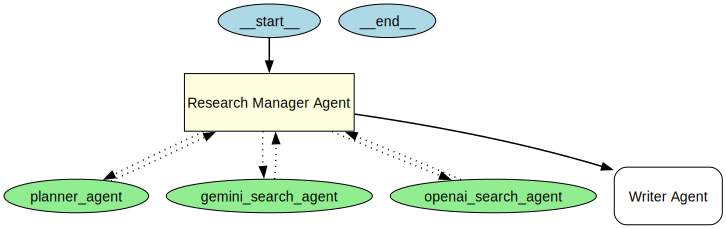

In [252]:
from agents.extensions.visualization import draw_graph
draw_graph(research_manager_agent)

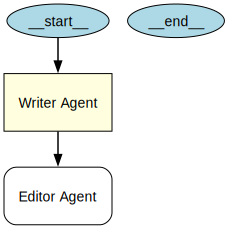

In [247]:
from agents.extensions.visualization import draw_graph
draw_graph(writer_agent)

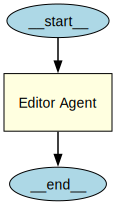

In [248]:
from agents.extensions.visualization import draw_graph
draw_graph(editor_agent)